# Implement Optimization Models

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')
import math

In [2]:
# Load the forecasts we created
forecasts_df = pd.read_csv('../data/demand_forecasts.csv')
forecasts_df['date'] = pd.to_datetime(forecasts_df['date'])

# Load product information
products_files = [f for f in os.listdir('../data/') if f.startswith('products_')]
products_file = sorted(products_files)[-1]
products_df = pd.read_csv(f'../data/{products_file}')

# Load inventory data to get current inventory levels
inventory_files = [f for f in os.listdir('../data/') if f.startswith('inventory_') and not f.startswith('inventory_metrics')]
inventory_file = sorted(inventory_files)[-1]
inventory_df = pd.read_csv(f'../data/{inventory_file}')

inventory_metrics_df = pd.read_csv('../data/inventory_metrics.csv')

# Filter for just inventory records and convert date
inventory_df['date'] = pd.to_datetime(inventory_df['date'])
inventory_records = inventory_df[inventory_df['event_type'] == 'inventory']

# Get the most recent inventory level for each product
latest_inventory = inventory_records.sort_values('date').groupby('product_id').last().reset_index()
latest_inventory = latest_inventory[['product_id', 'date', 'quantity']]
latest_inventory.columns = ['product_id', 'last_updated', 'current_inventory']

# Merge product information with latest inventory
product_inventory = pd.merge(products_df, latest_inventory, on='product_id')
product_inventory = pd.merge(product_inventory, inventory_metrics_df[['product_id', 'avg_inventory', 'inventory_turnover', 'days_of_supply', 'stockout_rate']], on='product_id')

# Display the merged data
print("Product Inventory Status:")
display(product_inventory)

Product Inventory Status:


,product_id,product_name,category,price,holding_cost_rate,stockout_cost_rate,setup_cost,lead_time_mean,lead_time_std,seasonal_pattern,trend_factor,last_updated,current_inventory,avg_inventory,inventory_turnover,days_of_supply,stockout_rate
0,P001,Electronics Item 1,Electronics,81.00,0.191001,0.472321,52.364712,7,2,weekly,-0.2,2023-12-31,52,159.590411,194.880130,1.872946,0.238356
1,P002,Home Goods Item 2,Home Goods,40.64,0.165373,0.378613,30.612112,6,2,weekly,-0.1,2023-12-31,198,124.549315,283.807261,1.286084,0.276712
2,P003,Home Goods Item 3,Home Goods,44.41,0.183214,0.424754,27.038993,6,2,yearly,0.1,2023-12-31,61,108.556164,368.767635,0.989783,0.305479
3,P004,Food Item 4,Food,9.11,0.235766,0.631619,13.806631,3,1,monthly,-0.2,2023-12-31,206,111.905479,259.996205,1.403867,0.209589
4,P005,Food Item 5,Food,11.39,0.255186,0.636855,15.689195,3,1,weekly,-0.2,2023-12-31,195,101.253425,311.080836,1.173328,0.230137
5,P006,Home Goods Item 6,Home Goods,41.58,0.172554,0.410291,32.312710,6,2,quarterly,0.2,2023-12-31,0,106.834247,405.768762,0.899527,0.316438
6,P007,Clothing Item 7,Clothing,32.45,0.136375,0.283674,19.157552,5,1,none,-0.1,2023-12-31,145,124.782192,261.752094,1.394449,0.247945
7,P008,Electronics Item 8,Electronics,95.21,0.198136,0.533411,46.626541,7,2,quarterly,-0.1,2023-12-31,322,141.701370,232.580673,1.569348,0.256164
8,P009,Food Item 9,Food,10.81,0.259177,0.548568,15.404935,3,1,weekly,-0.1,2023-12-31,126,87.887671,399.168615,0.914401,0.260274
9,P010,Clothing Item 10,Clothing,29.55,0.143098,0.325523,20.752648,5,1,yearly,0.0,2023-12-31,0,118.006849,308.575309,1.182855,0.279452


In [3]:
# Calculate aggregate forecast statistics by product
forecast_stats = forecasts_df.groupby('product_id').agg({
    'forecast_demand': ['mean', 'std', 'min', 'max', 'sum']
}).reset_index()
forecast_stats.columns = ['product_id', 'avg_daily_demand', 'std_daily_demand', 'min_daily_demand', 'max_daily_demand', 'total_forecast_demand']

# Merge with product information
product_forecast = pd.merge(product_inventory, forecast_stats, on='product_id')

# Display the forecast statistics
print("\nProduct Forecast Statistics:")
display(product_forecast)


Product Forecast Statistics:


,product_id,product_name,category,price,holding_cost_rate,stockout_cost_rate,setup_cost,lead_time_mean,lead_time_std,seasonal_pattern,...,current_inventory,avg_inventory,inventory_turnover,days_of_supply,stockout_rate,avg_daily_demand,std_daily_demand,min_daily_demand,max_daily_demand,total_forecast_demand
0,P001,Electronics Item 1,Electronics,81.00,0.191001,0.472321,52.364712,7,2,weekly,...,52,159.590411,194.880130,1.872946,0.238356,40.925333,5.060151,36.71,50.47,1227.76
1,P002,Home Goods Item 2,Home Goods,40.64,0.165373,0.378613,30.612112,6,2,weekly,...,198,124.549315,283.807261,1.286084,0.276712,49.101000,5.101490,43.66,58.13,1473.03
2,P003,Home Goods Item 3,Home Goods,44.41,0.183214,0.424754,27.038993,6,2,yearly,...,61,108.556164,368.767635,0.989783,0.305479,58.909000,0.783271,57.90,62.16,1767.27
3,P004,Food Item 4,Food,9.11,0.235766,0.631619,13.806631,3,1,monthly,...,206,111.905479,259.996205,1.403867,0.209589,40.226333,1.924047,38.39,46.98,1206.79
4,P005,Food Item 5,Food,11.39,0.255186,0.636855,15.689195,3,1,weekly,...,195,101.253425,311.080836,1.173328,0.230137,41.370667,5.077549,37.04,50.67,1241.12
5,P006,Home Goods Item 6,Home Goods,41.58,0.172554,0.410291,32.312710,6,2,quarterly,...,0,106.834247,405.768762,0.899527,0.316438,56.477000,2.191263,49.36,59.50,1694.31
6,P007,Clothing Item 7,Clothing,32.45,0.136375,0.283674,19.157552,5,1,none,...,145,124.782192,261.752094,1.394449,0.247945,44.256333,2.046692,41.89,52.44,1327.69
7,P008,Electronics Item 8,Electronics,95.21,0.198136,0.533411,46.626541,7,2,quarterly,...,322,141.701370,232.580673,1.569348,0.256164,41.950333,0.928772,41.06,45.50,1258.51
8,P009,Food Item 9,Food,10.81,0.259177,0.548568,15.404935,3,1,weekly,...,126,87.887671,399.168615,0.914401,0.260274,48.061667,5.158487,42.61,56.76,1441.85
9,P010,Clothing Item 10,Clothing,29.55,0.143098,0.325523,20.752648,5,1,yearly,...,0,118.006849,308.575309,1.182855,0.279452,50.443000,0.402545,49.11,51.00,1513.29


# Inventory Optimization Models

## 1. Economic Order Quantity (EOQ) Model
 - EOQ = sqrt(2 * D * S / H)
 - Where:
 - D = Annual demand
 - S = Setup (ordering) cost
 - H = Holding cost per unit per year

In [4]:
def calculate_eoq(annual_demand, setup_cost, holding_cost_rate, unit_price):
    """Calculate the Economic Order Quantity"""
    holding_cost = holding_cost_rate * unit_price  # Annual holding cost per unit
    eoq = math.sqrt(2 * annual_demand * setup_cost / holding_cost)
    return eoq

## 2. Reorder Point (ROP) Model
 - ROP = L * D + Z * σL
 - Where:
 - L = Lead time (in days)
 - D = Average daily demand
 - Z = Safety factor (based on service level)
 - σL = Standard deviation of demand during lead time

In [5]:
def calculate_reorder_point(lead_time, daily_demand, safety_factor, std_demand):
    """Calculate the Reorder Point"""
    # Adjust standard deviation for lead time
    std_lead_time = std_demand * math.sqrt(lead_time)
    rop = lead_time * daily_demand + safety_factor * std_lead_time
    return rop

## 3. Safety Stock
 - SS = Z * σL
 - Where:
 - Z = Safety factor (based on service level)
 - σL = Standard deviation of demand during lead time

In [6]:
def calculate_safety_stock(safety_factor, std_demand, lead_time):
    """Calculate Safety Stock"""
    std_lead_time = std_demand * math.sqrt(lead_time)
    safety_stock = safety_factor * std_lead_time
    return safety_stock

## 4. Total Annual Cost
 - TC = D * P + D/Q * S + Q/2 * H
 - Where:
 - D = Annual demand
 - P = Unit price
 - Q = Order quantity
 - S = Setup (ordering) cost
 - H = Holding cost per unit per year

In [7]:
def calculate_total_cost(annual_demand, unit_price, order_quantity, setup_cost, holding_cost_rate):
    """Calculate Total Annual Cost"""
    holding_cost = holding_cost_rate * unit_price  # Annual holding cost per unit
    purchase_cost = annual_demand * unit_price
    ordering_cost = (annual_demand / order_quantity) * setup_cost
    holding_cost_total = (order_quantity / 2) * holding_cost
    return purchase_cost + ordering_cost + holding_cost_total

# Service level to Z-score mapping (for normal distribution)
service_level_to_z = {
    0.50: 0.00,
    0.75: 0.67,
    0.80: 0.84,
    0.85: 1.04,
    0.90: 1.28,
    0.95: 1.65,
    0.98: 2.05,
    0.99: 2.33
}

# Calculate optimal inventory parameters for each product
inventory_optimization = []

for _, row in product_forecast.iterrows():
    product_id = row['product_id']
    product_name = row['product_name']
    category = row['category']
    
    # Extract parameters
    annual_demand = row['avg_daily_demand'] * 365  # Annualized from daily average
    unit_price = row['price']
    setup_cost = row['setup_cost']
    holding_cost_rate = row['holding_cost_rate']
    lead_time = row['lead_time_mean']
    std_demand = row['std_daily_demand']
    current_inventory = row['current_inventory']
    
    # Calculate optimal parameters for different service levels
    results = []
    
    for service_level in [0.80, 0.90, 0.95, 0.98]:
        safety_factor = service_level_to_z[service_level]
        
        # Calculate EOQ
        eoq = calculate_eoq(annual_demand, setup_cost, holding_cost_rate, unit_price)
        
        # Round up to integer
        eoq = math.ceil(eoq)
        
        # Calculate safety stock
        safety_stock = calculate_safety_stock(safety_factor, std_demand, lead_time)
        
        # Calculate reorder point
        rop = calculate_reorder_point(lead_time, row['avg_daily_demand'], safety_factor, std_demand)
        
        # Calculate total cost
        total_cost = calculate_total_cost(annual_demand, unit_price, eoq, setup_cost, holding_cost_rate)
        
        # Days of supply with optimal inventory
        optimal_days_supply = safety_stock / row['avg_daily_demand']
        
        # Calculate order quantity based on current inventory
        days_until_reorder = max(0, (current_inventory - rop) / row['avg_daily_demand'])
        
        # Calculate order urgency
        if current_inventory <= rop:
            order_urgency = 'High - Order Now'
            recommended_order = eoq
        else:
            order_urgency = f'Low - Order in {days_until_reorder:.1f} days'
            recommended_order = 0
        
        results.append({
            'product_id': product_id,
            'product_name': product_name,
            'category': category,
            'service_level': service_level,
            'optimal_order_quantity': eoq,
            'reorder_point': math.ceil(rop),
            'safety_stock': math.ceil(safety_stock),
            'total_annual_cost': total_cost,
            'current_inventory': current_inventory,
            'avg_daily_demand': row['avg_daily_demand'],
            'lead_time': lead_time,
            'days_until_reorder': days_until_reorder,
            'order_urgency': order_urgency,
            'recommended_order': recommended_order,
            'optimal_days_supply': optimal_days_supply
        })
    
    inventory_optimization.extend(results)

# Convert to DataFrame
optimization_df = pd.DataFrame(inventory_optimization)

# Display optimization results
print("\nInventory Optimization Results:")
selected_columns = [
    'product_id', 'product_name', 'service_level', 
    'optimal_order_quantity', 'reorder_point', 'safety_stock',
    'current_inventory', 'order_urgency', 'recommended_order'
]
display(optimization_df[selected_columns])


Inventory Optimization Results:


,product_id,product_name,service_level,optimal_order_quantity,reorder_point,safety_stock,current_inventory,order_urgency,recommended_order
0,P001,Electronics Item 1,0.80,318,298,12,52,High - Order Now,318
1,P001,Electronics Item 1,0.90,318,304,18,52,High - Order Now,318
2,P001,Electronics Item 1,0.95,318,309,23,52,High - Order Now,318
3,P001,Electronics Item 1,0.98,318,314,28,52,High - Order Now,318
4,P002,Home Goods Item 2,0.80,405,306,11,198,High - Order Now,405
5,P002,Home Goods Item 2,0.90,405,311,16,198,High - Order Now,405
6,P002,Home Goods Item 2,0.95,405,316,21,198,High - Order Now,405
7,P002,Home Goods Item 2,0.98,405,321,26,198,High - Order Now,405
8,P003,Home Goods Item 3,0.80,379,356,2,61,High - Order Now,379
9,P003,Home Goods Item 3,0.90,379,356,3,61,High - Order Now,379


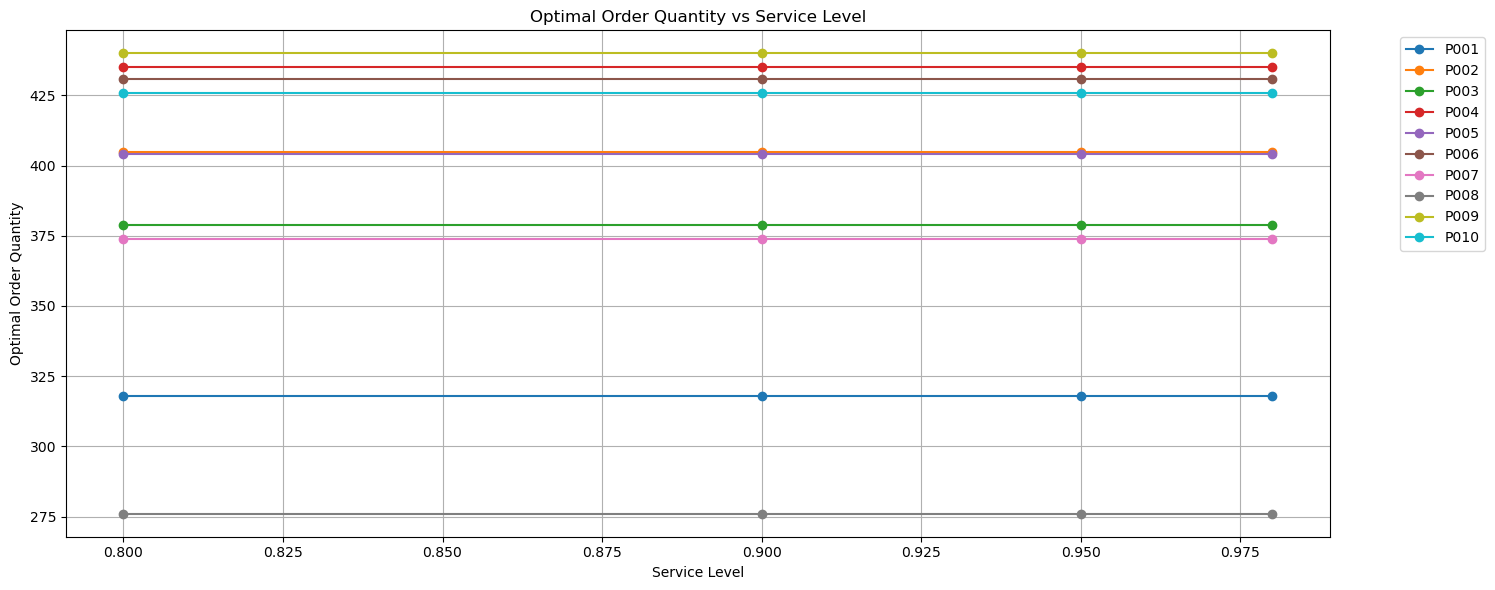

In [8]:
# Plot order quantities vs service level
plt.figure(figsize=(15, 6))
for product_id in optimization_df['product_id'].unique():
    product_data = optimization_df[optimization_df['product_id'] == product_id]
    plt.plot(product_data['service_level'], product_data['optimal_order_quantity'], marker='o', label=product_id)

plt.title('Optimal Order Quantity vs Service Level')
plt.xlabel('Service Level')
plt.ylabel('Optimal Order Quantity')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

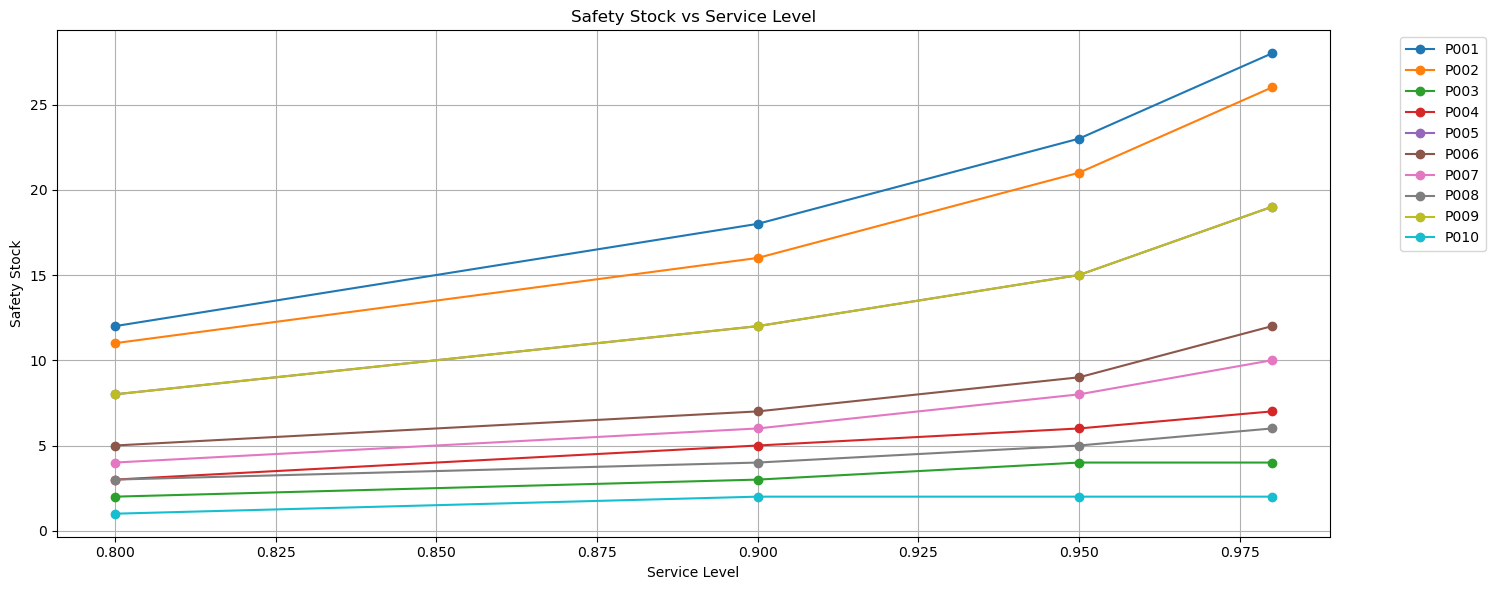

In [9]:
# Plot safety stock vs service level
plt.figure(figsize=(15, 6))
for product_id in optimization_df['product_id'].unique():
    product_data = optimization_df[optimization_df['product_id'] == product_id]
    plt.plot(product_data['service_level'], product_data['safety_stock'], marker='o', label=product_id)

plt.title('Safety Stock vs Service Level')
plt.xlabel('Service Level')
plt.ylabel('Safety Stock')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

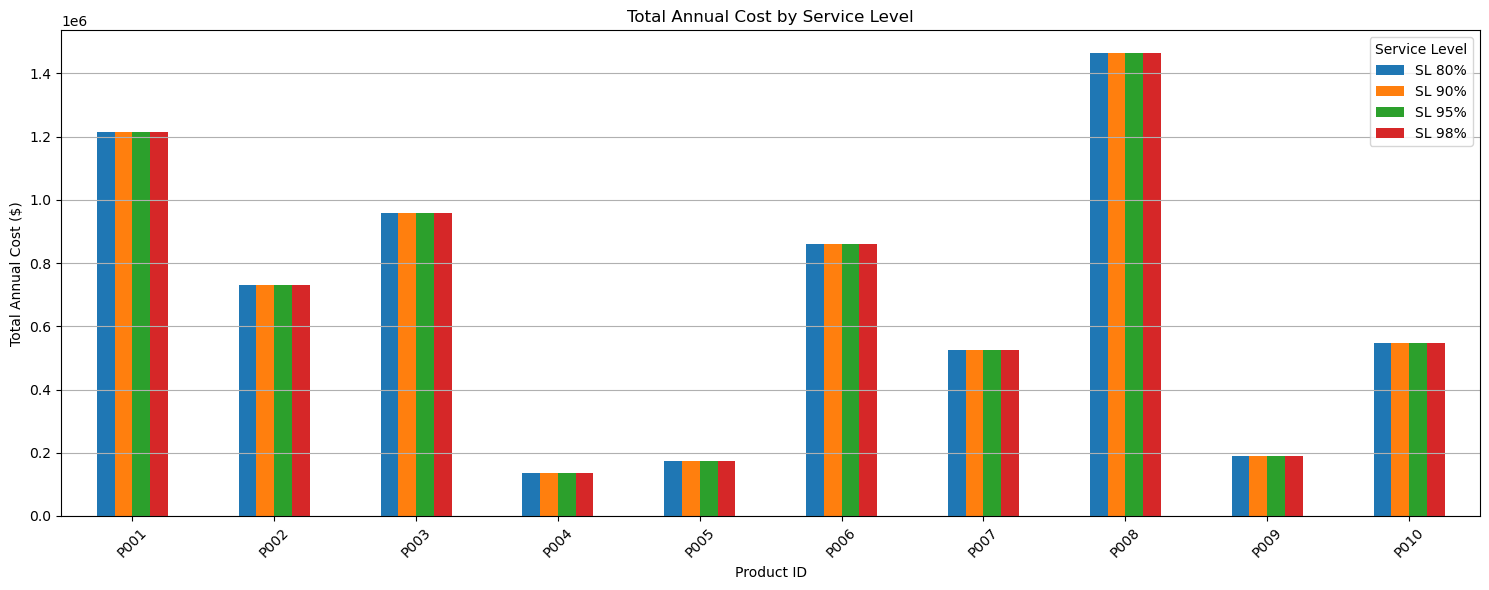

In [10]:
# Compare total costs across service levels
service_level_costs = optimization_df.pivot(index='product_id', columns='service_level', values='total_annual_cost')
service_level_costs.columns = [f'SL {sl:.0%}' for sl in service_level_costs.columns]

plt.figure(figsize=(15, 8))
ax = service_level_costs.plot(kind='bar', figsize=(15, 6))
plt.title('Total Annual Cost by Service Level')
plt.xlabel('Product ID')
plt.ylabel('Total Annual Cost ($)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.legend(title='Service Level')
plt.tight_layout()
plt.show()

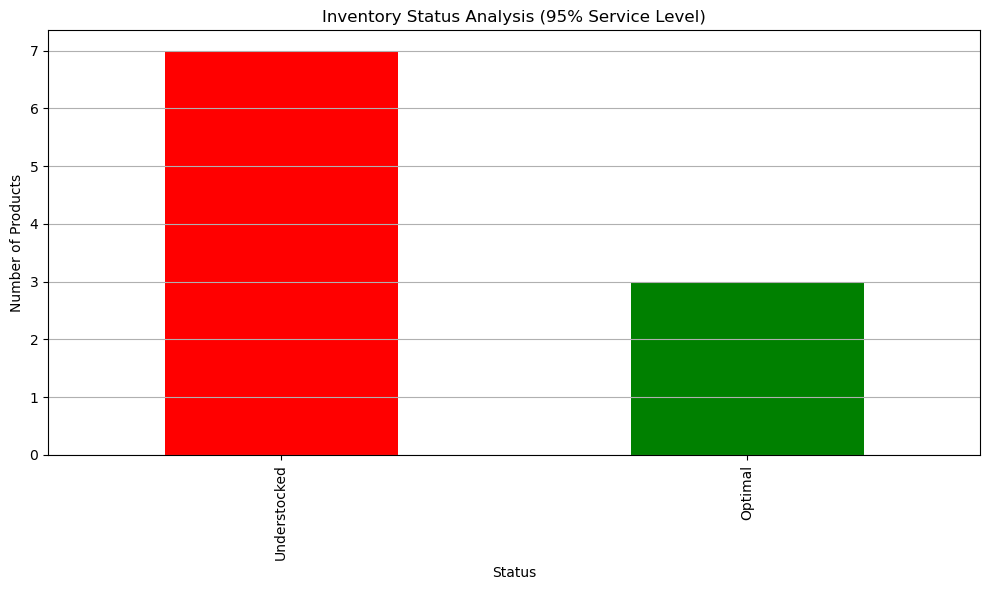

In [11]:
# Calculate current stock status
stock_status = optimization_df[optimization_df['service_level'] == 0.95].copy()
stock_status['inventory_status'] = stock_status.apply(
    lambda x: 'Understocked' if x['current_inventory'] < x['reorder_point'] else
              ('Overstocked' if x['current_inventory'] > x['reorder_point'] + x['optimal_order_quantity'] else 'Optimal'),
    axis=1
)

# Count of products by inventory status
status_counts = stock_status['inventory_status'].value_counts()

plt.figure(figsize=(10, 6))
status_counts.plot(kind='bar', color=['red', 'green', 'orange'])
plt.title('Inventory Status Analysis (95% Service Level)')
plt.xlabel('Status')
plt.ylabel('Number of Products')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

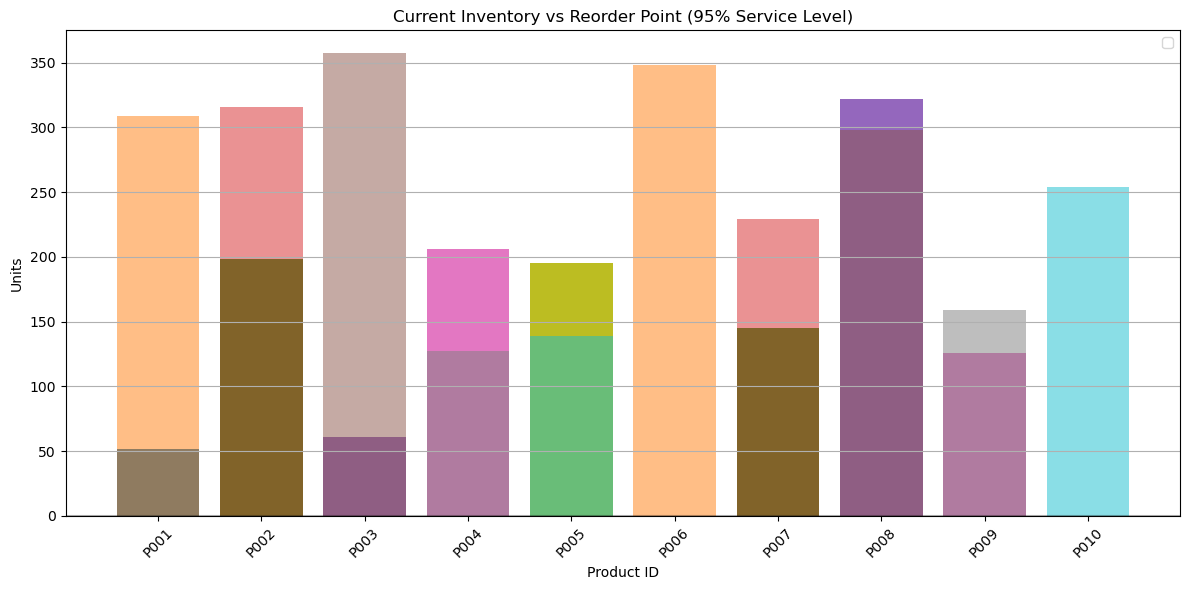

In [12]:
# Plot current inventory vs reorder point
plt.figure(figsize=(12, 6))
for index, row in stock_status.iterrows():
    plt.bar(row['product_id'], row['current_inventory'], label='Current Inventory' if index == 0 else "")
    plt.bar(row['product_id'], row['reorder_point'], alpha=0.5, label='Reorder Point' if index == 0 else "")

plt.title('Current Inventory vs Reorder Point (95% Service Level)')
plt.xlabel('Product ID')
plt.ylabel('Units')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Calculate potential cost savings
 - Baseline: Current average inventory and stockout rate
 - Optimized: Proposed safety stock and service level


Potential Cost Savings Analysis (95% Service Level):


,product_id,product_name,current_total_cost,optimized_annual_cost,potential_savings
30,P008,Electronics Item 8,5.129624e+06,1.463033e+06,3.666590e+06
14,P004,Food Item 4,3.042325e+06,1.346918e+05,2.907633e+06
6,P002,Home Goods Item 2,3.624836e+06,7.310602e+05,2.893775e+06
18,P005,Food Item 5,2.969765e+06,1.731659e+05,2.796599e+06
34,P009,Food Item 9,2.237432e+06,1.908651e+05,2.046567e+06
26,P007,Clothing Item 7,2.379135e+06,5.258381e+05,1.853297e+06
10,P003,Home Goods Item 3,1.435510e+06,9.579701e+05,4.775399e+05
2,P001,Electronics Item 1,9.129806e+05,1.214877e+06,-3.018966e+05
38,P010,Clothing Item 10,4.949267e+04,5.458632e+05,-4.963705e+05
22,P006,Home Goods Item 6,1.112834e+05,8.602261e+05,-7.489428e+05


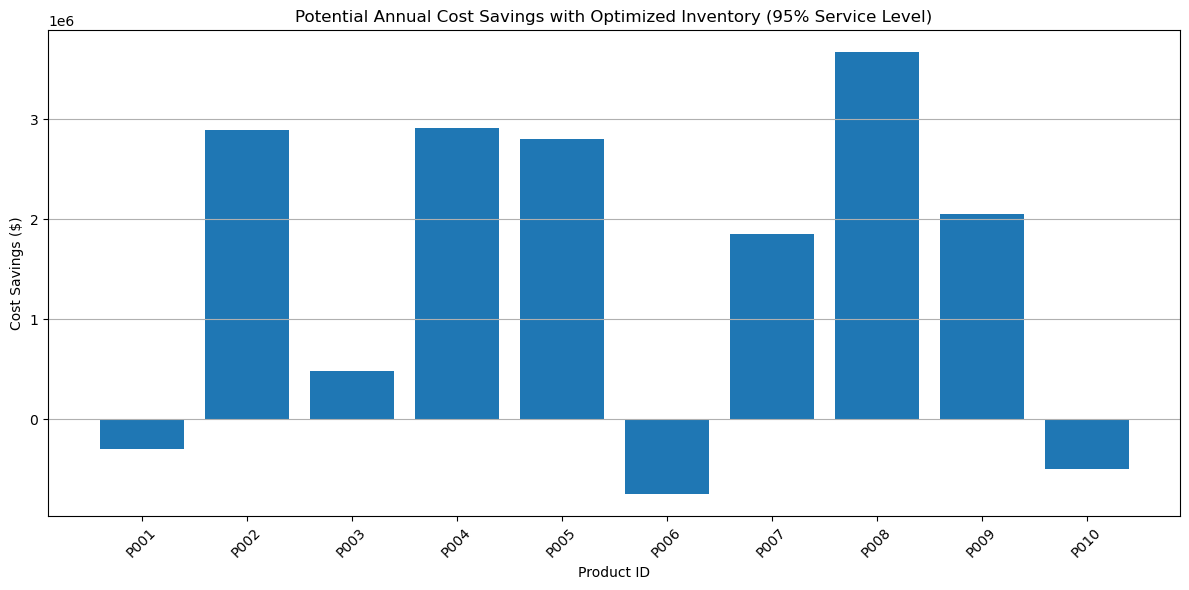

In [13]:
# Calculate current annual holding cost
stock_status['current_annual_holding_cost'] = stock_status['current_inventory'] * stock_status['avg_daily_demand'] * 365

# Calculate current annual stockout cost (rough approximation)
# Assume each stockout leads to lost sales
products = product_forecast.set_index('product_id')
stock_status['current_annual_stockout_cost'] = products.loc[stock_status['product_id'], 'stockout_rate'].values * 365 * stock_status['avg_daily_demand'] * products.loc[stock_status['product_id'], 'price'].values * products.loc[stock_status['product_id'], 'stockout_cost_rate'].values

# Calculate optimized costs
stock_status['optimized_annual_cost'] = stock_status['total_annual_cost']

# Calculate potential savings
stock_status['current_total_cost'] = stock_status['current_annual_holding_cost'] + stock_status['current_annual_stockout_cost']
stock_status['potential_savings'] = stock_status['current_total_cost'] - stock_status['optimized_annual_cost']

# Display potential savings
print("\nPotential Cost Savings Analysis (95% Service Level):")
savings_columns = [
    'product_id', 'product_name', 'current_total_cost', 'optimized_annual_cost', 'potential_savings'
]
display(stock_status[savings_columns].sort_values('potential_savings', ascending=False))

# Plot potential savings
plt.figure(figsize=(12, 6))
plt.bar(stock_status['product_id'], stock_status['potential_savings'])
plt.title('Potential Annual Cost Savings with Optimized Inventory (95% Service Level)')
plt.xlabel('Product ID')
plt.ylabel('Cost Savings ($)')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Calculate recommended reorder schedule
today = latest_inventory['last_updated'].max()
forecast_window = 30  # days

reorder_schedule = []

for _, row in stock_status.iterrows():
    product_id = row['product_id']
    product_name = row['product_name']
    
    current_inventory = row['current_inventory']
    daily_demand = row['avg_daily_demand']
    reorder_point = row['reorder_point']
    optimal_order_quantity = row['optimal_order_quantity']
    lead_time = row['lead_time']
    
    # Calculate days until inventory reaches reorder point
    if current_inventory <= reorder_point:
        days_until_reorder = 0  # Reorder now
        reorder_date = today
    else:
        days_until_reorder = (current_inventory - reorder_point) / daily_demand
        reorder_date = today + timedelta(days=int(days_until_reorder))
    
    # Calculate expected delivery date
    expected_delivery = reorder_date + timedelta(days=int(lead_time))
    
    # Calculate expected inventory at delivery
    if days_until_reorder == 0:
        expected_inventory = max(0, current_inventory - (lead_time * daily_demand))
    else:
        expected_inventory = max(0, reorder_point - (lead_time * daily_demand))
    
    # Calculate days of coverage after delivery
    days_of_coverage = (expected_inventory + optimal_order_quantity) / daily_demand
    
    reorder_schedule.append({
        'product_id': product_id,
        'product_name': product_name,
        'current_inventory': current_inventory,
        'reorder_point': reorder_point,
        'days_until_reorder': days_until_reorder,
        'reorder_date': reorder_date,
        'order_quantity': optimal_order_quantity,
        'expected_delivery': expected_delivery,
        'expected_inventory_at_delivery': expected_inventory,
        'days_of_coverage_after_delivery': days_of_coverage
    })

reorder_schedule_df = pd.DataFrame(reorder_schedule)

# Sort by urgency (days until reorder)
reorder_schedule_df = reorder_schedule_df.sort_values('days_until_reorder')

# Display reorder schedule
print("\nRecommended Reorder Schedule:")
display(reorder_schedule_df)

# Save optimization results to CSV
optimization_df.to_csv('../data/inventory_optimization_results.csv', index=False)
stock_status.to_csv('../data/inventory_stock_status.csv', index=False)
reorder_schedule_df.to_csv('../data/reorder_schedule.csv', index=False)

print("Inventory optimization complete!")


Recommended Reorder Schedule:


,product_id,product_name,current_inventory,reorder_point,days_until_reorder,reorder_date,order_quantity,expected_delivery,expected_inventory_at_delivery,days_of_coverage_after_delivery
0,P001,Electronics Item 1,52,309,0.000000,2023-12-31,318,2024-01-07,0.000000,7.770248
1,P002,Home Goods Item 2,198,316,0.000000,2023-12-31,405,2024-01-06,0.000000,8.248305
2,P003,Home Goods Item 3,61,357,0.000000,2023-12-31,379,2024-01-06,0.000000,6.433652
5,P006,Home Goods Item 6,0,348,0.000000,2023-12-31,431,2024-01-06,0.000000,7.631425
6,P007,Clothing Item 7,145,229,0.000000,2023-12-31,374,2024-01-05,0.000000,8.450768
8,P009,Food Item 9,126,159,0.000000,2023-12-31,440,2024-01-03,0.000000,9.154905
9,P010,Clothing Item 10,0,254,0.000000,2023-12-31,426,2024-01-05,0.000000,8.445176
7,P008,Electronics Item 8,322,298,0.572105,2023-12-31,276,2024-01-07,4.347667,6.682847
4,P005,Food Item 5,195,139,1.353616,2024-01-01,404,2024-01-04,14.888000,10.125242
3,P004,Food Item 4,206,127,1.963888,2024-01-01,435,2024-01-04,6.321000,10.970948


Inventory optimization complete!
